## LSTM Forecasting: 

This notebook introduces how to train a Long Short-Term Memory (LSTM) network for time-series forecasting.  
We start with a synthetic dataset that combines a trend and cyclical patterns, then build an LSTM model  
to predict future values. The purpose is to develop intuition before applying the method to real financial data.

**Sections:**

0. Introduction
1. Setup and Imports  
2. Data Generation  
3. Sliding Window Construction  
4. LSTM Model Definition  
5. Training and Evaluation  
6. Visualization
7. Hyperparemeter Tuning

## LSTM Forecasting — What We’re Building

<p align="center">
  <img src="figures/lstm_architecture.png" alt="LSTM architecture" width="450">
</p>


**Goal:** Construct a synthetic time series combining a clear trend, cyclical observables, and heteroskedastic noise, then train an LSTM to forecast future values. 

**Why LSTMs?**  
LSTMs excel when the target depends on **history** (lags, seasonality, regimes). Their gates decide what to **keep**, **write**, and **expose**, letting the model remember useful patterns and forget noise—perfect for forecasting.

#### Data we’ll build:

- **Observables:** for example, $f_1(t),f_2(t)$, and time.  
- **Trend:** a linear term added directly to the target so forecasts drift sensibly up or down  
- **Noise:** heteroskedastic (time-varying)
- **Windows → Forecasts:** use windows of length $L$, $X_{t-L+1:t}$, to predict $y_{t+1}$ (one-step ahead)

### LSTM cell — generic dimensions with explicit matrices

Let $D$ be the dimension of the feature vector $x_t$ and $H$ the dimension of the hidden vector $h_{t-1}$. For clarity, the matrices below are shown in the single-sample view ($B=1$); in practice, the batch dimension broadcasts.

#### Inputs and states

- Input at time $t$  
  $$
  x_t =
  \begin{bmatrix}
  x_1 & x_2 & \cdots & x_D
  \end{bmatrix}
  \in \mathbb{R}^{1\times D}
  $$
- Previous hidden state  
  $$
  h_{t-1} =
  \begin{bmatrix}
  h_1 & h_2 & \cdots & h_H
  \end{bmatrix}
  \in \mathbb{R}^{1\times H}
  $$
- Previous cell state  
  $$
  c_{t-1} =
  \begin{bmatrix}
  c_1 & c_2 & \cdots & c_H
  \end{bmatrix}
  \in \mathbb{R}^{1\times H}
  $$

#### Forget gate

Think of it as a filter. It decides what fraction of past information in the cell state should be kept versus forgotten.

  * If $f_t \approx 1$, the LSTM keeps that piece of memory.

  * If $f_t \approx 0$, it erases it.
→ This helps the network drop irrelevant past patterns (e.g., outdated market conditions).

Parameters:
$$
W_f =
\begin{bmatrix}
W^f_{11} & W^f_{12} & \cdots & W^f_{1D} \\
W^f_{21} & W^f_{22} & \cdots & W^f_{2D} \\
\vdots   & \vdots   & \ddots & \vdots   \\
W^f_{H1} & W^f_{H2} & \cdots & W^f_{HD}
\end{bmatrix}
\in \mathbb{R}^{H\times D},\qquad
U_f =
\begin{bmatrix}
U^f_{11} & U^f_{12} & \cdots & U^f_{1H} \\
U^f_{21} & U^f_{22} & \cdots & U^f_{2H} \\
\vdots   & \vdots   & \ddots & \vdots   \\
U^f_{H1} & U^f_{H2} & \cdots & U^f_{HH}
\end{bmatrix}
\in \mathbb{R}^{H\times H},\qquad
b_f =
\begin{bmatrix}
b^f_{1} & b^f_{2} & \cdots & b^f_{H}
\end{bmatrix}
\in \mathbb{R}^{H}
$$

Computation:
$$
z_f = x_t W_f^\top + h_{t-1} U_f^\top + b_f,\qquad
f_t = \sigma(z_f)\in\mathbb{R}^{1\times H}
$$

#### Input gate

This gate controls how much new information from the current input should enter the cell state.

  * If $i_t$ is high, new data (like a new market trend) is strongly written into memory.

  * If it’s low, the model ignores the current signal.

Parameters:
$$
W_i\in\mathbb{R}^{H\times D},\quad
U_i\in\mathbb{R}^{H\times H},\quad
b_i\in\mathbb{R}^{H}
$$

Computation:
$$
z_i = x_t W_i^\top + h_{t-1} U_i^\top + b_i,\qquad
i_t = \sigma(z_i)\in\mathbb{R}^{1\times H}
$$

#### Candidate (cell proposal)

This generates a proposal for new content that could be added to the memory.
It transforms the input and hidden state through a $\tanh$ layer to create a vector of possible new values.

  * The input gate then scales how much of this proposal actually enters memory.

  * So $\widehat{c}_t$ is what could be remembered, $i_t$ is how much of it actually is.

Parameters:
$$
W_{\widehat{c}}\in\mathbb{R}^{H\times D},\quad
U_{\widehat{c}}\in\mathbb{R}^{H\times H},\quad
b_{\widehat{c}}\in\mathbb{R}^{H}
$$

Computation:
$$
z_{\widehat{c}} = x_t W_{\widehat{c}}^\top + h_{t-1} U_{\widehat{c}}^\top + b_{\widehat{c}},\qquad
\widehat{c}_t = \tanh(z_{\widehat{c}})\in\mathbb{R}^{1\times H}
$$

#### Cell update

Update memory by mixing the retained past and the selected new content:
$$
c_t = f_t \odot c_{t-1} + i_t \odot \widehat{c}_t \;\;\in\;\mathbb{R}^{1\times H}
$$

#### Output gate and hidden state

Once the cell memory has been updated, this gate decides what part of that memory becomes visible to the next layer or to the final prediction.

  * It’s like reading only a filtered summary of what the memory currently holds.
  * When we train our LSTM to forecast $y_{t+1}$, the prediction will come directly from $h_t$, because it encodes all relevant context the model currently “remembers.”

Parameters:
$$
W_o\in\mathbb{R}^{H\times D},\quad
U_o\in\mathbb{R}^{H\times H},\quad
b_o\in\mathbb{R}^{H}
$$

Computation:
$$
z_o = x_t W_o^\top + h_{t-1} U_o^\top + b_o,\qquad
o_t = \sigma(z_o),\qquad
h_t = o_t \odot \tanh(c_t)\in\mathbb{R}^{1\times H}
$$


In summary, the LSTM maintains a **cell state** $c_t$ as long-term memory and a **hidden state** $h_t$ as its visible output. The four gates collaboratively decide what to erase, what new information to write, and what to expose at each step —enabling the model to capture long-range dependencies in time-series data.


## 1. Setup and Imports

We import the required libraries and set a fixed random seed for reproducibility.  
The device configuration automatically detects GPU availability.

In [16]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

SEED = 100
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
g = torch.Generator().manual_seed(SEED)

print(f"Using device: {device}")

Using device: cuda


## 2. Data Generation:

In [17]:
def construct_variables(T=3000, noise_std=1, seed=SEED):
  '''
  Generate a synthetic time series with multiple observable features and one target variable.

  The target depends on lagged feature values, a deterministic trend, and heteroskedastic noise.
  Useful for testing LSTM forecasting models.

  Parameters
  ----------
  T : int, optional
      Total number of time steps to generate. Default is 4000.
  noise_std : float, optional
      Base standard deviation of the noise. Default is 0.05.
  seed : int, optional
      Random seed for reproducibility. Default is 42.

  Returns
  -------
  t : ndarray of shape (T-5,)
      Time index (excluding initial lags).
  X : ndarray of shape (T-5, 3)
      Matrix of observable features.
  y : ndarray of shape (T-5,)
      Target variable for forecasting.
  vol : ndarray of shape (T-5,)
      Realized volatility (used to generate heteroskedastic noise).
  '''
  
  rng = np.random.default_rng(seed)
  t = np.arange(T)

  # 1. Observable features 
  f1 = np.sin(0.2 * t)
  f2 = np.cos(0.15 * t + 0.5)
  f3 = t.astype(np.float32)

  X = np.stack([f1, f2, f3], axis=1)

  # 2. Deterministic trend and noise
  trend = 0.002 * t
  vol = noise_std * (5 * np.abs(np.sin(0.01 * t)))
  noise = rng.normal(0, vol)

  # 3. Target construction with lags 
  max_lag = 5  # largest lag used
  y = 0.5 * np.roll(f1, 1) - 0.3 * np.roll(f2, 3) + trend + noise

  # 4. Discard initial contaminated observations
  t, X, y, vol = t[max_lag:], X[max_lag:], y[max_lag:], vol[max_lag:]

  # 5. Return results
  return t.astype(np.float32), X.astype(np.float32), y.astype(np.float32), vol.astype(np.float32)

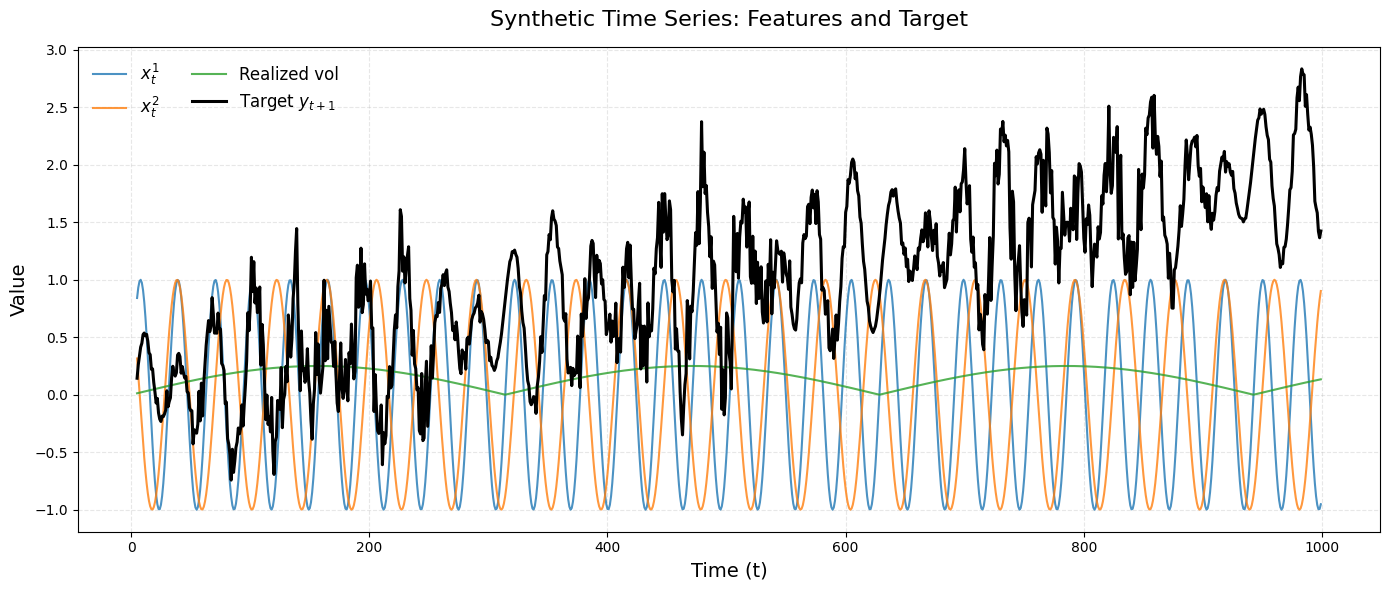

In [18]:
# Construct the dataset:
t, X_all, y_all, vol_all = construct_variables(T=1000, noise_std=0.05, seed=42) # shape (T-5, 3), (T-5,), (T-5,)

# Plot all components and the target:
plt.figure(figsize=(14, 6))

# plot last 1000 points for clarity:
window = 1000
t_plot = t[-window:]
X_plot = X_all[-window:]
y_plot = y_all[-window:]

plt.plot(t_plot, X_plot[:, 0], label="$x^{1}_t$", alpha=0.8, linewidth=1.5)
plt.plot(t_plot, X_plot[:, 1], label="$x^{2}_t$", alpha=0.8, linewidth=1.5)
plt.plot(t_plot, vol_all[-window:], label="Realized vol", alpha=0.8, linewidth=1.5)
plt.plot(t_plot, y_plot, label="Target $y_{t+1}$", color="black", linewidth=2.2)

plt.title("Synthetic Time Series: Features and Target", fontsize=16, pad=15)
plt.xlabel("Time (t)", fontsize=14)
plt.ylabel("Value", fontsize=14)

plt.legend(fontsize=12, ncol=2, frameon=False)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## 3. Sliding Windows

We now:
1. Create sliding windows for one-step-ahead forecasting.  
2. Split the data chronologically into training, validation, and test sets.  
3. Normalize each feature using training-set statistics only (no look-ahead).  
4. Convert to PyTorch tensors and wrap into `DataLoader`s.

In [19]:
def create_sliding_windows(X, y, seq_len=20):
    """
    Turn (X, y) into sliding windows for sequence forecasting.

    Parameters
    ----------
    X : array (T, n_features)
    y : array (T,)
    seq_len : int, number of lags to use as input

    Returns
    -------
    X_seq : (n_samples, seq_len, n_features)
    y_seq : (n_samples,)
    """
    n_samples = len(X) - seq_len     # len(X) returns number of rows (t)
    X_seq = []
    y_seq = []
    for i in range(n_samples):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])

    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

In [20]:
def train_val_test_split(X_seq, y_seq, train_frac=0.7, val_frac=0.2):
    """
    Split into train, validation, test sets (time-ordered).
    """
    n = len(X_seq)
    n_train = int(n * train_frac)
    n_val   = int(n * val_frac)

    X_train, y_train = X_seq[:n_train], y_seq[:n_train]
    X_val,   y_val   = X_seq[n_train:n_train+n_val], y_seq[n_train:n_train+n_val]
    X_test,  y_test  = X_seq[n_train+n_val:], y_seq[n_train+n_val:]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [21]:
# Create sliding windows:
X_seq, y_seq = create_sliding_windows(X_all, y_all, seq_len=25)

# Split into train, val, test:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(X_seq, y_seq, train_frac=0.7, val_frac=0.2)

# Normalize using training set statistics:
mean = X_train.mean(axis=(0, 1), keepdims=True)  # average over samples and time
std  = X_train.std(axis=(0, 1), keepdims=True)

# Standardize (zero mean, unit variance for the train set):
X_train = (X_train - mean) / std
X_val   = (X_val - mean) / std
X_test  = (X_test - mean) / std

print("Feature means after normalization (train):", X_train.mean(axis=(0,1)))
print("Feature stds after normalization (train):", X_train.std(axis=(0,1)))

Feature means after normalization (train): [ 5.7289370e-08 -4.0457422e-08  4.2557189e-09]
Feature stds after normalization (train): [1.0000025  0.99999344 1.0000125 ]


In [22]:
# Convert NumPy arrays to torch tensors
train_X_t = torch.tensor(X_train)   # shape: (n_train, seq_len, n_features)
train_y_t = torch.tensor(y_train)   # shape: (n_train,)
val_X_t   = torch.tensor(X_val)
val_y_t   = torch.tensor(y_val)
test_X_t  = torch.tensor(X_test)
test_y_t  = torch.tensor(y_test)

# Wrap into TensorDataset
train_ds = TensorDataset(train_X_t, train_y_t)
val_ds   = TensorDataset(val_X_t, val_y_t)
test_ds  = TensorDataset(test_X_t, test_y_t)

# If on CUDA: pin_memory speeds host→device copies
pin = (device.type == "cuda")

# Create DataLoaders (batches)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=pin, generator=g)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, pin_memory=pin)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=pin)

## 4. LSTM Model definition

In [23]:
# Define a simple LSTM forecaster:
class LSTMForecaster(nn.Module):

    '''
    LSTM-based model for one-step-ahead time series forecasting.
    Uses the final hidden state of the top LSTM layer to predict y_{t+1}.
    '''

    def __init__(self, n_features, hidden_size, num_layers):

        # Call parent constructor:
        super().__init__()

        # LSTM layer:       
        self.lstm = nn.LSTM(
            input_size=n_features,              # input_size = number of features per time step (t)
            hidden_size=hidden_size,            # hidden_size = size of hidden state
            num_layers=num_layers,              # num_layers = how many stacked LSTM layers
            batch_first=True,                   # batch_first=True -> input/output shape is (batch, seq_len, features)
        )

        self.fc = nn.Linear(hidden_size, 1)     # Fully connected layer: maps hidden state -> scalar prediction

    def forward(self, x):

        '''
        Forward pass through the model.
        x : (batch, seq_len, n_features)
        Returns: (batch,) tensor of predictions.
        '''
        
        # out: LSTM outputs from the top layer at all time steps
        #      shape = (batch, seq_len, hidden_size)
        # h_n: final hidden states for all layers
        #      shape = (num_layers, batch, hidden_size)
        # c_n: final cell states for all layers
        #      shape = (num_layers, batch, hidden_size)
        out, (h_n, c_n) = self.lstm(x)

        # Take the hidden state from the last layer:
        last_hidden = h_n[-1]   # shape: (batch, hidden_size)

        # Project through fully connected layer and flatten last dimension
        y_pred = self.fc(last_hidden).squeeze(-1)  # shape = (batch,)

        return y_pred

In [24]:
# Model setup: Input has 3 features per time step
model = LSTMForecaster(n_features=3, hidden_size=64, num_layers=1)
model = model.to(device)  # Move model to GPU if available

# Loss function: Mean Squared Error is standard for regression/forecasting
criterion = nn.MSELoss()

# Optimizer: Adam combines the benefits of momentum and adaptive learning rates
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Diagnostics
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {n_params:,} trainable parameters")
print(model)

Model has 17,729 trainable parameters
LSTMForecaster(
  (lstm): LSTM(3, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 5. Training and Evaluation

In [25]:
n_epochs = 100  # number of passes over the dataset
patience = 10   # for early stopping
best_val_loss = np.inf
train_losses = []
val_losses = []

for epoch in range(n_epochs):

    # TRAINING:

    model.train()                               # set model to training mode 
    train_loss = 0.0

    for xb, yb in train_loader:

        # Move batch to device
        xb, yb = xb.to(device), yb.to(device)
        
        # Forward pass
        preds = model(xb)                       # shape: (batch,)
        loss = criterion(preds, yb)             # compute MSE loss

        # Backward pass
        optimizer.zero_grad()                   # reset gradients
        loss.backward()                         # compute gradients
        optimizer.step()                        # update weights

        train_loss += loss.item() * xb.size(0)  # accumulate total loss per batch

    train_loss /= len(train_loader.dataset)     # average over all training samples
    train_losses.append(train_loss)

    # VALIDATION:

    model.eval()                                # set model to evaluation mode (disables dropout, etc.)
    val_loss = 0.0
    with torch.no_grad():                       # no gradients for validation
        for xb, yb in val_loader:
            # Move batch to device
            xb, yb = xb.to(device), yb.to(device)

            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:2d}/{n_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # --- EARLY STOPPING CHECK ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # save best model weights
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)  # restore best weights
            break

Epoch  1/100 - Train Loss: 0.2211 - Val Loss: 0.0556
Epoch  2/100 - Train Loss: 0.0380 - Val Loss: 0.0501
Epoch  3/100 - Train Loss: 0.0329 - Val Loss: 0.0643
Epoch  4/100 - Train Loss: 0.0308 - Val Loss: 0.0664
Epoch  5/100 - Train Loss: 0.0306 - Val Loss: 0.0877
Epoch  6/100 - Train Loss: 0.0320 - Val Loss: 0.0618
Epoch  7/100 - Train Loss: 0.0323 - Val Loss: 0.0531
Epoch  8/100 - Train Loss: 0.0315 - Val Loss: 0.0501
Epoch  9/100 - Train Loss: 0.0299 - Val Loss: 0.0511
Epoch 10/100 - Train Loss: 0.0302 - Val Loss: 0.0641
Epoch 11/100 - Train Loss: 0.0298 - Val Loss: 0.0562
Epoch 12/100 - Train Loss: 0.0293 - Val Loss: 0.0540
Early stopping at epoch 12


## 6. Visualization

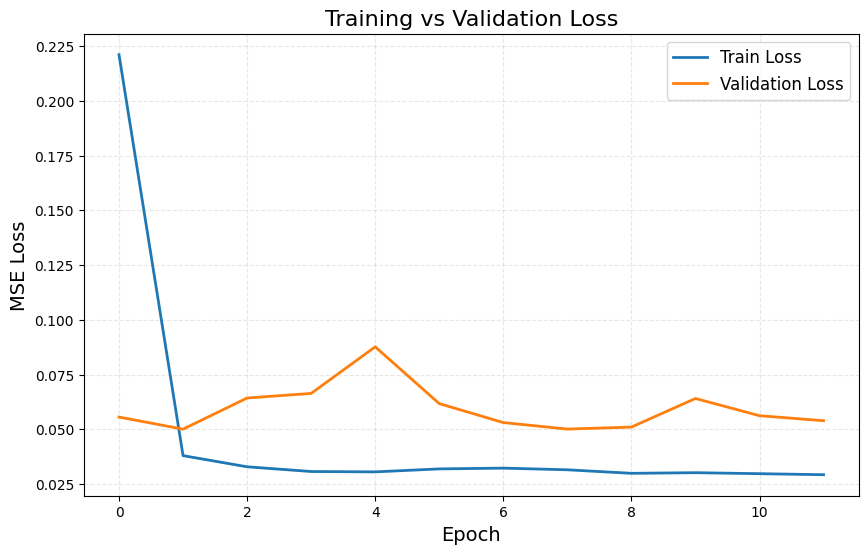

In [26]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Train Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("MSE Loss", fontsize=14)
plt.title("Training vs Validation Loss", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3, linestyle="--")
plt.show()


In [27]:
model.eval()  # set to evaluation mode

all_preds = []
all_true = []

with torch.no_grad():  # no gradients during evaluation
    for xb, yb in test_loader:
        # Move batch to device
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)          # forecasts
        all_preds.append(preds.cpu().numpy()) 
        all_true.append(yb.cpu().numpy())

# Concatenate all batches into single arrays
all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)

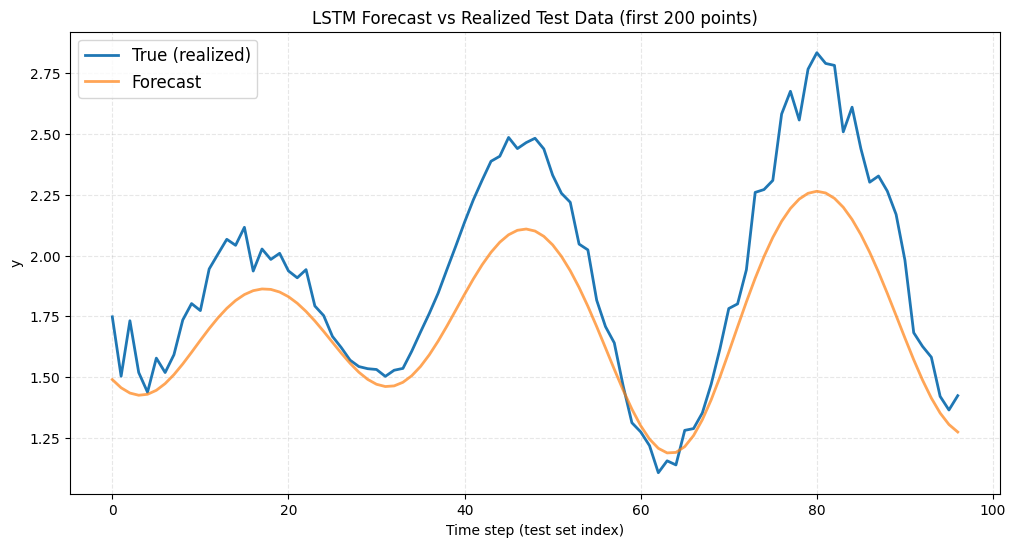

In [28]:
plt.figure(figsize=(12,6))
plt.plot(all_true[:200], label="True (realized)", linewidth=2)
plt.plot(all_preds[:200], label="Forecast", linewidth=2, alpha=0.7)
plt.title("LSTM Forecast vs Realized Test Data (first 200 points)")
plt.xlabel("Time step (test set index)")
plt.ylabel("y")
plt.legend(fontsize=12)
plt.grid(alpha=0.3, linestyle="--")
plt.show()

### 7 Hyperparameter Tuning

Hyperparameter tuning focuses on finding a balance between model capacity, training stability, and generalization.

Key hyperparameters to tune:
- **Learning rate:** has the largest effect on convergence.
- **Hidden size:** controls how much memory the model has.
- **Sequence length:** determines how far back in time the model looks.

In [ ]:
# Define search space
hidden_sizes = [16, 32, 64]
learning_rates = [1e-2, 1e-3, 5e-4]
seq_lens = [10, 20, 40]

search_space = list(itertools.product(hidden_sizes, learning_rates, seq_lens))

results = []

# Function to train and evaluate quickly on a given configuration
def run_experiment(hidden_size, lr, seq_len):
    # Recreate the windowed dataset for this sequence length
    X_seq, y_seq = create_sliding_windows(X_all, y_all, seq_len=seq_len)
    (X_train, y_train), (X_val, y_val), _ = train_val_test_split(X_seq, y_seq)

    # Normalize using training statistics
    mean = X_train.mean(axis=(0, 1), keepdims=True)
    std = X_train.std(axis=(0, 1), keepdims=True) + 1e-8
    X_train = (X_train - mean) / std
    X_val   = (X_val - mean) / std

    # Convert to tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_val_t   = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t   = torch.tensor(y_val, dtype=torch.float32).to(device)

    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds   = TensorDataset(X_val_t, y_val_t)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

    # Model, optimizer, and loss
    model = LSTMForecaster(n_features=3, hidden_size=hidden_size, num_layers=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val = np.inf
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        if val_loss < best_val:
            best_val = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break  # early stop

    return best_val


# Run grid search
for hidden_size, lr, seq_len in search_space:
    print(f"Testing: hidden={hidden_size}, lr={lr}, seq_len={seq_len}")
    best_val = run_experiment(hidden_size, lr, seq_len)
    results.append({
        "hidden_size": hidden_size,
        "lr": lr,
        "seq_len": seq_len,
        "best_val_loss": best_val
    })


Testing: hidden=16, lr=0.01, seq_len=10
Testing: hidden=16, lr=0.01, seq_len=20
Testing: hidden=16, lr=0.01, seq_len=40
Testing: hidden=16, lr=0.001, seq_len=10
Testing: hidden=16, lr=0.001, seq_len=20
Testing: hidden=16, lr=0.001, seq_len=40
Testing: hidden=16, lr=0.0005, seq_len=10
Testing: hidden=16, lr=0.0005, seq_len=20
Testing: hidden=16, lr=0.0005, seq_len=40
Testing: hidden=32, lr=0.01, seq_len=10
Testing: hidden=32, lr=0.01, seq_len=20
Testing: hidden=32, lr=0.01, seq_len=40
Testing: hidden=32, lr=0.001, seq_len=10
Testing: hidden=32, lr=0.001, seq_len=20
Testing: hidden=32, lr=0.001, seq_len=40
Testing: hidden=32, lr=0.0005, seq_len=10
Testing: hidden=32, lr=0.0005, seq_len=20
Testing: hidden=32, lr=0.0005, seq_len=40
Testing: hidden=64, lr=0.01, seq_len=10
Testing: hidden=64, lr=0.01, seq_len=20
Testing: hidden=64, lr=0.01, seq_len=40
Testing: hidden=64, lr=0.001, seq_len=10
Testing: hidden=64, lr=0.001, seq_len=20
Testing: hidden=64, lr=0.001, seq_len=40
Testing: hidden=64,

In [30]:
# Display results
results_df = pd.DataFrame(results).sort_values("best_val_loss").reset_index(drop=True)
display(results_df.head(20))

,hidden_size,lr,seq_len,best_val_loss
0,32,0.0100,20,0.045886
1,64,0.0100,10,0.046438
2,32,0.0100,10,0.047145
3,64,0.0010,20,0.047620
4,64,0.0100,20,0.047658
5,32,0.0100,40,0.047857
6,64,0.0005,40,0.048136
7,64,0.0100,40,0.048272
8,64,0.0010,10,0.049318
9,64,0.0005,10,0.049666
